In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html -q
!pip install --upgrade kornia -q
!pip install allennlp==1.1.0.rc4 -q
!pip install --upgrade fastai -q

ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

from fastai.text.all import *

1.6.0+cu101
True
2.0.15


In [3]:
path = Path('../input/nlp-getting-started')
Path.BASE_PATH = path
path.ls()

(#3) [Path('sample_submission.csv'),Path('test.csv'),Path('train.csv')]

In [141]:
submisson = pd.read_csv(path/'sample_submission.csv')
submisson.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [5]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# DataLoaders

In [7]:
blocks = (TextBlock.from_df(text_cols='text', is_lm=True))

In [8]:
text_df = pd.Series.append(train_df['text'], test_df['text'])
text_df = pd.DataFrame(text_df)
text_df.head()

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [9]:
get_x = ColReader('text')
splitter = RandomSplitter(0.1, seed=42)

In [10]:
lm_dblock = DataBlock(blocks=blocks,
                     get_x=get_x,
                     splitter=splitter)

In [11]:
lm_dls = lm_dblock.dataloaders(text_df, bs=64)

In [12]:
lm_learn = language_model_learner(lm_dls, AWD_LSTM, pretrained=True, metrics=[accuracy, Perplexity()])

In [13]:
lm_learn.to_fp16()
lm_learn.fine_tune(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.384785,4.257415,0.330318,70.627197,00:23


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.423968,3.849662,0.371900,46.977161,00:23
1,4.143733,3.629686,0.389230,37.700981,00:24
2,3.918951,3.448576,0.410596,31.455566,00:24
3,3.702000,3.320057,0.425776,27.661924,00:24
4,3.540380,3.233136,0.437725,25.359056,00:24
5,3.418756,3.177827,0.444036,23.994566,00:23
6,3.323097,3.143380,0.448658,23.182100,00:24
7,3.282275,3.125216,0.451747,22.764812,00:23
8,3.238952,3.119746,0.452294,22.640621,00:23
9,3.221892,3.118345,0.452446,22.608942,00:24


In [14]:
lm_learn.save_encoder('fine_tuned')

# Classification

In [71]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [82]:
blocks = (TextBlock.from_df('text', seq_len=lm_dls.seq_len, vocab=lm_dls.vocab), CategoryBlock(vocab={0,1}))

In [83]:
toxic_clas = DataBlock(blocks=blocks,
                      get_x=ColReader('text'),
                      get_y=ColReader('target'),
                      splitter=RandomSplitter())

In [84]:
dls = toxic_clas.summary(train_df[:10])

Setting-up type transforms pipelines
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   
5   8     NaN      NaN   
6  10     NaN      NaN   
7  13     NaN      NaN   
8  14     NaN      NaN   
9  15     NaN      NaN   

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4 

Setting up Pipeline: ColReader -- {'cols': 'target', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': (#2) [0,1], 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 'text', 'pref': '', 'suff': '', 'label_delim': None} -> Tokenizer -> Numericalize
    starting from
      id                                                                                                                                                                                                 8
keyword                                                                                                                                                                                          NaN
location                                                                                                                                                                                         NaN
target                                                                          

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorText of size 29, TensorCategory(1))
    applying ToTensor gives
      (TensorText of size 29, TensorCategory(1))

Adding the next 3 samples

Applying before_batch to the list of samples
  Pipeline: partial
    starting from
      [(TensorText of size 29, TensorCategory(1)), (TensorText of size 21, TensorCategory(1)), (TensorText([   2,    8,   89,   31,   70,   97,  310, 1276,   83,   18,   14,  618,
         919,   14,  719]), TensorCategory(1)), (TensorText([   2,  810, 2811,    5,   48,  149,   88, 4544,   13, 1385,  310, 1702,
          18,    8,  135]), TensorCategory(1))]
    applying partial gives
      [(TensorText of size 29, TensorCategory(1)), (TensorText of size 29, TensorCategory(1)), (TensorText of size 29, TensorCategory(1)), (TensorText of si

In [105]:
ds = toxic_clas.datasets(train_df)
ds[0]

(TensorText([   2,    8,  144,    8,    0,   42,   14,    8,  873,   19,   39,   13,
          288,    8,  184,    7, 1815,    8, 3801,  122,   65]),
 TensorCategory(1))

In [98]:
dls = toxic_clas.dataloaders(train_df)

In [99]:
dls.show_batch()

,text,category
0,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
3,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
5,xxbos xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup au # xxup jp xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
6,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
7,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
8,xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk p xxup xxunk xxmaj gem xxmaj bu xxup pl xxmaj blazing xxup ms xxrep 6 + xxmaj xxunk xxmaj rare xxmaj proof xxmaj like ! - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0


In [100]:
xb, yb = dls.one_batch()
xb.shape , yb.shape

(torch.Size([64, 64]), torch.Size([64]))

In [107]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.002511886414140463)

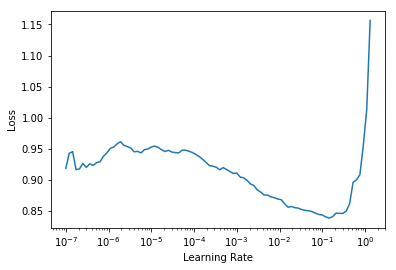

In [108]:
learn.lr_find()

In [109]:
learn.load_encoder('fine_tuned');

In [110]:
learn.to_fp16()

lr = 1e-2
moms = (0.8,0.7, 0.8)
lr *= learn.dls.bs/128
learn.fit_one_cycle(1, lr, moms=moms, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.660088,0.461520,0.781209,00:14


In [111]:
learn.freeze_to(-2)
lr/=2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=0.1)


epoch,train_loss,valid_loss,accuracy,time
0,0.577818,0.443837,0.796978,00:15


# Prediction on test dataset

In [112]:
dl = learn.dls.test_dl(test_df['text'])

In [113]:
preds = learn.get_preds(dl=dl)

In [134]:
labels = np.argmax(preds[0], axis=1)
labels

tensor([0, 1, 1,  ..., 1, 1, 1])

In [138]:
submisson.head()

,id,target,t
0,0,True,0
1,2,False,1
2,3,False,1
3,9,False,1
4,11,False,1


In [142]:
submisson['target'] = labels

In [143]:
submisson.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
